In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
# TODO -- should we be calculating transcript TPM from the unfiltered or filtered abundance file? 
# 3/9/22 ali says let's go with filtered for now

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 75389


In [4]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [5]:
gene_df, _, _ = get_gtf_info(how='gene')

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} ({:.2f}%) annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

Detected 25332 / 49472 (51.20%) annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## TF gene transcript detection

What fraction of TF genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [6]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='tf')

# merge with gene id
gene_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

gene_df, _, _ = get_gtf_info(how='gene', subset='tf')

n_tf = len(gene_df.index)
n_det_tf = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} ({:.2f}%) annotated TF genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_tf, n_tf, (n_det_tf/n_tf)*100))

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 4644
Detected 1314 / 1419 (92.60%) annotated TF genes w/ at least 1 known transcript >= 1 TPM


Which TF has the most isoforms overall? 

In [7]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='all', 
                       nov=['Known', 'NIC', 'NNC'])
gene_df, _, _ = get_gtf_info(how='gene')
df = df.merge(gene_df[['gid', 'gname']], 
              how='left', 
              left_index=True, 
              right_on='gid')
df = df.sort_values(by='all', ascending=False)
df.head(10)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 5951


,all,gid,gname
296,33,ENSG00000074800.15,ENO1
28813,28,ENSG00000095794.19,CREM
48846,26,ENSG00000196628.16,TCF4
16169,26,ENSG00000081189.15,MEF2C
50804,25,ENSG00000181666.17,HKR1
48103,24,ENSG00000177426.20,TGIF1
31284,23,ENSG00000007372.22,PAX6
51738,23,ENSG00000130844.17,ZNF331
8381,23,ENSG00000115415.18,STAT1
9207,23,ENSG00000124831.18,LRRFIP1


Which TF has the most isoforms expressed in a single sample? 

In [8]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])
df['max_sample'] = df.max(1)
df = df['max_sample'].to_frame()

gene_df, _, _ = get_gtf_info(how='gene')
df = df.merge(gene_df[['gid', 'gname']], 
              how='left', 
              left_index=True, 
              right_on='gid')

df = df.sort_values(by='max_sample', ascending=False)
df.head(10)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 5951
Found 50 total samples


,max_sample,gid,gname
296,28.0,ENSG00000074800.15,ENO1
8381,23.0,ENSG00000115415.18,STAT1
28813,23.0,ENSG00000095794.19,CREM
48846,21.0,ENSG00000196628.16,TCF4
50804,20.0,ENSG00000181666.17,HKR1
38047,18.0,ENSG00000198176.12,TFDP1
25914,18.0,ENSG00000185122.10,HSF1
48103,18.0,ENSG00000177426.20,TGIF1
15672,18.0,ENSG00000062194.15,GPBP1
50642,17.0,ENSG00000089335.20,ZNF302


## Protein coding gene transcript detection

What fraction of protein-coding genes do we detect with at least 1 known isoform >= 1 TPM in any library?

In [9]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
# no gene subset here so we can look at all other genes
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1)

Calculating iso TPM values
Subsetting for novelty categories ['Known']


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 77590


In [10]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [11]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')
df = df.merge(gene_df, how='left', left_on='annot_gene_id', right_on='gid')

In [12]:
temp = df[['gid', 'biotype_category']].drop_duplicates().groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,17198,19969,0.861235
0,lncRNA,4973,15006,0.331401
2,other,1844,7426,0.248317
4,pseudogene,3161,14497,0.218045
1,miRNA,350,1881,0.186071


## What fraction of protein coding gene transcripts do we detect?

Of the transcripts associated with protein coding genes GENCODE, how many do we detect >=1 TPM?

In [13]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 75389


In [14]:
t_df, b_counts, b_cat_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [15]:
temp = df[['tid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'tid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
1,protein_coding,64393.0,151259,0.425714
0,lncRNA,7314.0,28478,0.256830
2,pseudogene,3682.0,17657,0.208529
3,miRNA,NaN,1881,NaN
4,other,NaN,7486,NaN


In [16]:
73508.0 / 197394

0.3723922712949735

## Characteristics of detected known, polyA gene associated transcripts

## Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 75389
Found 50 total samples


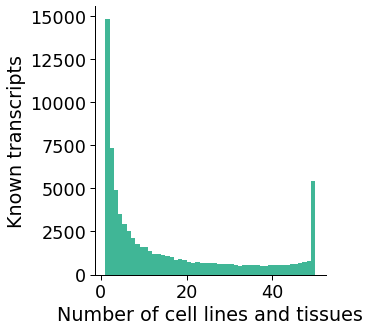

In [17]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_biosamp_det(df,
                      how='iso',
                      min_tpm=1,
                      gene_subset='polya',
                      sample=None,
                      groupby='sample',
                      nov='Known',
                      opref='figures/human')

In [18]:
specific_thresh = 8
ubiq_thresh = 30

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

39800 / 75389 (52.8%) transcripts are expressed in <= 8 samples
16267 / 75389 (21.6%) transcripts are expressed in >= 30 samples


## Length of transcripts from polyA genes detected >= 1 TPM

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 75389


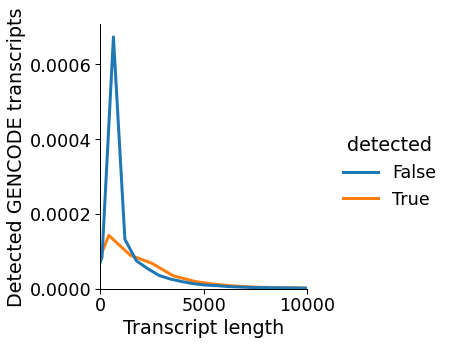

In [19]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='iso', 
                      subset='polya',
                      min_tpm=1,
                      xlim=10000,
                      opref='figures/')

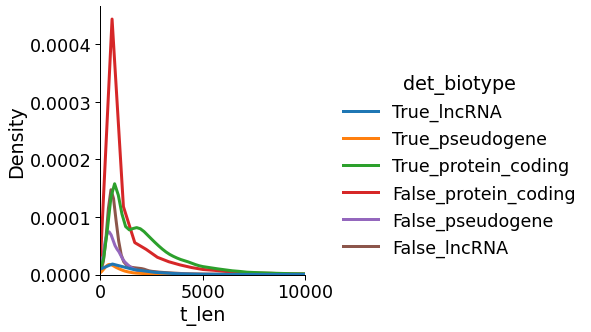

In [20]:
df['det_biotype'] = df.detected.astype('str')+'_'+df.biotype_category
ax = sns.displot(data=df, x='t_len', kind='kde',
                     linewidth=3, hue='det_biotype', common_norm=True)
ax.set(xlim=(0,10000))

What is the longest detected transcript with more than one exon?

In [21]:
t_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
t_df = t_df[['annot_transcript_id', 'n_exons']]

In [22]:
df = df.merge(t_df, how='left', on='annot_transcript_id')

In [23]:
n = df.loc[(df.detected == True)&(df.n_exons > 1), 't_len'].max()
print(n)

37852


In [24]:
df.loc[df.t_len == 37852]

,annot_transcript_id,tid,t_len,gid,gname,biotype,biotype_category,tf,detected,det_biotype,n_exons
71485,ENST00000458178.2,ENST00000458178.2,37852,ENSG00000224086.5,AC245452.1,antisense,lncRNA,False,True,True_lncRNA,2.0


## Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [25]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 75389


## How many known polyA transcripts do we detect?

In [26]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, _ = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 75389


In [27]:
# merge with transcript len
t_df, b_counts, c_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [28]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
n_det_polya = len(df.index)
n_known_polya = c_counts.loc[c_counts.biotype_category.isin(polya_biotypes), 'gencode_counts'].sum()
print('Detected {} / {} ({:.2f}%) annotated transcripts from polyA genes >= 1 TPM'.format(n_det_polya, n_known_polya, (n_det_polya/n_known_polya)*100))

Detected 75389 / 197394 (38.19%) annotated transcripts from polyA genes >= 1 TPM


## How many complete isoforms do we detect?

In [29]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 111071


  transcript_novelty  counts
0              Known   75389
1                NIC   27147
2                NNC    8535
Number of complete isoforms: 111071


<Figure size 288x432 with 0 Axes>

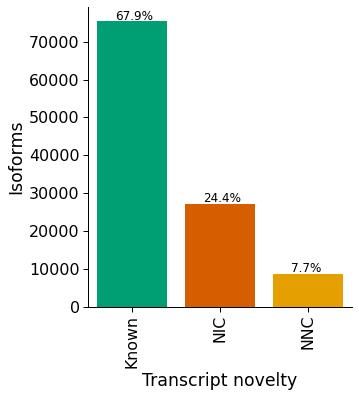

<Figure size 432x288 with 0 Axes>

In [30]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty(df,
                        oprefix='figures/complete_det',
                        whitelist=tids,
                        novs=['Known', 'NIC', 'NNC'])

In [31]:
25141+8038

33179

## How many exons are in each complete, detected model, split by novelty?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 111071


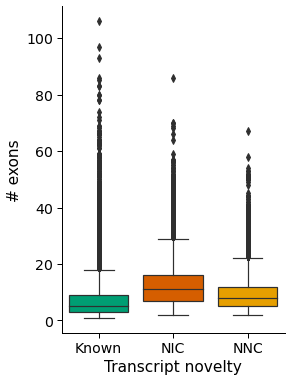

In [32]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_exons_per_iso(df,
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya',
                   opref='figures/human')

## How many isoforms per gene do we detect per sample? 

What is the average and range of complete isoforms per polyA gene that we detect per sample?

In [33]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 111071
Found 50 total samples


In [34]:
df.idxmax(axis=1)

annot_gene_id
ENSG00000000003.14              colon
ENSG00000000005.5        h9_panc_beta
ENSG00000000419.12    h9_neural_crest
ENSG00000000457.13    h9_neural_crest
ENSG00000000460.16     h9_panc_progen
                           ...       
ENSG00000285967.1                  h1
ENSG00000285972.1               colon
ENSG00000285976.1               colon
ENSG00000285988.1               calu3
ENSG00000285991.1                a673
Length: 25708, dtype: object

In [35]:
print('Average # isoforms / gene / sample: {}'.format(df.mean().mean()))

Average # isoforms / gene / sample: 2.9024639784673223


In [36]:
print('Max # isoforms / gene / sample: {}'.format(df.max().max()))

Max # isoforms / gene / sample: 134.0


How does the total # of isoforms we detect / gene compare to the number of annotated isoforms / gene

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 111071
1
[6. 6.]
2
[6. 6.]
[1.5914889588521772, 242.54016834549282]
242.54016834549282
242.54016834549282
ELN (140.81075240694724,34.189247593052755)
DES (46.810752406947245,4.189247593052755)
TPM1 (76.81075240694724,34.189247593052755)
MEF2C (27.810752406947245,56.189247593052755)
MYH7 (26.810752406947245,1.1892475930527553)
MAPK10 (69.81075240694724,192.18924759305276)
PAX6 (24.810752406947245,84.18924759305276)
TCF4 (27.810752406947245,90.18924759305276)
COL1A1 (4.810752406947245,13.189247593052755)


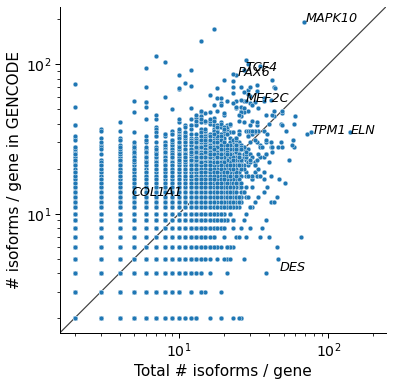

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
genes = ['ELN', 'DES', 'TPM1', 'MEF2C',
         'MYH7', 'MAPK10', 'PAX6', 'TCF4', 'COL1A1']
df = plot_det_vs_gencode_isos(df, 
                         min_tpm=1,
                         gene_subset='polya',
                         nov=['Known', 'NIC', 'NNC'],
                         label_genes=genes, 
                         opref='figures/human')

In [ ]:
entry = df.sort_values(by='n_isos_gencode', ascending=False).head(1)
print('{} has the most annotated isoforms in GENCODE ({})'.format(entry.gname.values[0], entry.n_isos_gencode.values[0]))

In [ ]:
genes = ['COL1A1', 'TPM1', 'MAPK10', 'ELN', 'DES']
df.loc[df.gname.isin(genes)]

In [ ]:
df.sort_values(by='n_isos_gencode', ascending=False).head()

In [ ]:
df.loc[df.gname == 'COL1A1']

In [ ]:
df.loc[df.gname == 'DES']

In [ ]:
df['ratio'] = df['n_isos_det'] / df['n_isos_gencode']
df.sort_values(by='ratio', ascending=False)
df = df.sort_values(by='ratio', ascending=True)
df.loc[df.n_isos_det > 15]

How does TPM for a gene in a sample relate to the number of models we see in a sample?

In [ ]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_gene_tpm_v_n_isos(df, filt_df, 
                            min_tpm=1, 
                            groupby='sample', 
                            gene_subset='polya', 
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

In [ ]:
df.loc[(df.gname == 'ELN')&(df.biosample == 'h9_chondro')]

In [ ]:
df.loc[df.tpm > 40000]

In [ ]:
df.loc[df.gname == 'COL1A1'].head()

How does the average number of exons in a gene relate to the number of isoforms we detect for that gene?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')

In [ ]:
g_df = df.copy(deep=True)

In [ ]:
g_df = g_df[['n_exons', 'annot_gene_id', 'annot_gene_name']]
g_df = g_df.groupby(['annot_gene_id', 'annot_gene_name']).mean().reset_index()
g_df.rename({'n_exons':'avg_exons'}, axis=1, inplace=True)

In [ ]:
g_df.head()

In [ ]:
# detected isoforms
df = get_isos_per_gene(df,
                   min_tpm=1,
                   gene_subset='polya',
                   groupby='all', 
                   nov=['Known', 'NIC', 'NNC'])
df.rename({'all': 'n_isos_det'}, axis=1, inplace=True)
df.head()

In [ ]:
# merge with # isos detected
df = df.merge(g_df, how='left', left_index=True, right_on='annot_gene_id')
df.head()

In [ ]:
xlim = 0
ylim = 0
label_genes = ['ELN', 'DES', 'TPM1', 'MYH7', 
               'SFTPA1', 'MGAT1', 'DYSF', 
               'COL16A1']

In [ ]:
# plot the figure
opref = 'figures/human'

sns.set_context('paper', font_scale=1.6)
ax = sns.scatterplot(data=df, x='n_isos_det', y='avg_exons')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set x and y lims if provided
if xlim:
    xlim = (0, xlim)
    ax.set(xlim=xlim)
if ylim:
    ylim = (0, ylim)
    ax.set(ylim=ylim)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# annotate genes that are kinda interesting
if label_genes:
    xlim = ax.get_xlim()[1]
    ylim = ax.get_ylim()[1]
    for g in label_genes:
        x = df.loc[df.annot_gene_name == g, 'n_isos_det'].values[0]+(2/75)*xlim
        y = df.loc[df.annot_gene_name == g, 'avg_exons'].values[0]-(1.5/75)*ylim
        plt.annotate(g, (x,y), fontsize='small', fontstyle='italic')

xlabel = 'Total # isoforms / gene'
ylabel = 'Average number of exons / isoform'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = '{}_isos_det_v_exons.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')


In [ ]:
df['ratio'] = df.n_isos_det / df.avg_exons
df = df.sort_values(by='ratio', ascending=True)
df.loc[df.n_isos_det > 5]

For genes where we detect a lot more isoforms than those annotated, are there typically more NIC or NNC?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
min_tpm=1
gene_subset='polya'
nov=['Known', 'NIC', 'NNC']
opref='figures/human'

In [ ]:
df_back = df.copy(deep=True)

In [ ]:
# detected isoforms
det_df = get_isos_per_gene(df,
                   min_tpm=min_tpm,
                   gene_subset=gene_subset,
                   groupby='all', 
                   nov=nov)
det_df.rename({'all': 'n_isos_det'}, axis=1, inplace=True)

# annotated isoforms
gc_df = get_n_gencode_isos(subset='polya')
gc_df = gc_df[['gid', 'n_isos_gencode']]

df = det_df.merge(gc_df, how='left', left_index=True, right_on='gid')    

# add gene name 
gene_df, _, _ = get_gtf_info(how='gene', subset='polya')
gene_df = gene_df[['gid', 'gname']]
df = df.merge(gene_df, how='left', on='gid')

df['ratio'] = df['n_isos_det'] / df['n_isos_gencode']
gids = df.loc[df['ratio']>1.5, 'gid'].tolist()
len(df.loc[df['ratio']>1.5])

In [ ]:
t_df = df_back.copy(deep=True)
t_df = t_df[['annot_transcript_id', 'transcript_novelty', 'annot_gene_id', 'annot_gene_name']]
df = get_det_table(df_back, 
                   how='iso', 
                   min_tpm=1, 
                   gene_subset='polya',
                   groupby='all',
                   nov=['Known', 'NIC', 'NNC'])
df = df.transpose()

In [ ]:
df = df.merge(t_df, how='left', left_index=True, right_on='annot_transcript_id')
df = df.loc[df.annot_gene_id.isin(gids)]

df.drop('all', axis=1, inplace=True)
df = df.groupby(['annot_gene_id', 'annot_gene_name', 'transcript_novelty'], dropna=False).count().reset_index()
df.rename({'annot_transcript_id': 'n_isos'}, axis=1, inplace=True)
df.head()

In [ ]:
# plot the plot
sns.set_context('paper', font_scale=1.6)
plt.figure(figsize=(4,6))

c_dict, order = get_talon_nov_colors(cats=nov)
# ax = sns.boxplot(data=df, x='transcript_novelty', y='n_isos',
#                  order=order, palette=c_dict,
#                  saturation=1)

ax = sns.catplot(data=df, x='transcript_novelty', y='n_isos',
                 order=order, palette=c_dict, kind='bar', saturation=1)


# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

xlabel = 'Transcript novelty'
ylabel = '# isoforms'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = '{}_isos_per_many_iso_gene.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')

How does the max # isoforms detected per gene / sample compare to the number of isoforms detected per gene overall across the whole dataset?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_max_vs_all_isos(df,
                         min_tpm=1,
                         gene_subset='polya',
                         nov=['Known', 'NIC', 'NNC'],
                         label_genes=['TPM1', 'DES', 'MAPK10', 'FN1', 'SFTPA1', 'ELN'],
                         xlim=75,
                         ylim=75,
                         opref='figures/human')

In [ ]:
df.loc[df.gname=='ELN']

In [ ]:
df['ratio'] = df['max_isos'] / df['total_isos']

In [ ]:
df.loc[df['total_isos'] > 50].sort_values(by='ratio', ascending=True)

What # of genes do we detect >15 isoforms overall that have >15 annotated isoforms in GENCODE?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='all', 
                       nov=['Known', 'NIC', 'NNC'])
df.head()

In [ ]:
df = df.loc[df['all'] > 15]

In [ ]:
gene_df, _, _ = get_gtf_info(how='iso', subset='polya')
gene_df = gene_df[['gid', 'tid']]
gene_df = gene_df.groupby('gid').count().reset_index()
gene_df.rename({'tid': 'n_isos_gencode'}, axis=1, inplace=True)
gene_df.sort_values(by='n_isos_gencode', ascending=False, inplace=True)
gene_df = gene_df.loc[gene_df.n_isos_gencode > 15]

# get intersection of genes wih >15 annotated isoforms and 
# genes that we detect >15 isoforms in at least one sample
n = len(set(gene_df.gid.tolist())&set(df.index.tolist()))
total = len(df.index)

print('{} / {} genes w/ >15 isoforms detected overall have >15 isoforms annotated in GENCODE'.format(n, total))

Deeper dive into what's going on with _ELN_

In [ ]:
temp = df.max(axis=1).to_frame()
temp.loc[temp[0] == 134]

In [ ]:
df.loc['ENSG00000049540.16'].idxmax()

How many different tissues express Elastin? How many isoforms are detected in these tissues?

In [ ]:
df.loc['ENSG00000049540.16']

What novelty type do each of these isoforms have across samples?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty_per(df, 
                            gene='ELN', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty_per(df, 
                            gene='DES', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty_per(df, 
                            gene='MYH7', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

What novelty type do each of these isoforms have in just h9 chondro?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty_per_1(df, 
                            dataset='h9_chondro',
                            gene='ELN',
                            min_tpm=1,
                            gene_subset='polya',
                            groupby='sample',
                            nov=['Known', 'NIC', 'NNC'], 
                            opref='figures/human')

Which samples have the highest average?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='all', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='tissue', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

What's the distribution of number of isoforms detected per gene per sample?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, ax = plot_isos_per_gene_hist(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'],
                       rm_1=True)

How many genes have >15, >10 isoforms expressed in a sample?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'])

In [ ]:
df = df.loc[(df > 10).any(axis=1)]
n = len(df.index)
print('{} genes with >10 complete isoforms / gene in at least one sample'.format(n))

In [ ]:
print(len(df.index))
df.head()

In [ ]:
# enrichr on these genes
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

df['gid'] = df.index
gids = df.gid.str.rsplit('.', n=1, expand=True)[0].to_frame()
df.drop('gid', axis=1, inplace=True)
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='highly_spliced_isos',
                outdir='highly_spliced_isos_GO',
                cutoff=0.5)

In [ ]:
df = df.loc[(df > 15).any(axis=1)]
n = len(df.index)
print('{} genes with >15 complete isoforms / gene in at least one sample'.format(n))

In [ ]:
# enrichr on these genes
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

df['gid'] = df.index
gids = df.gid.str.rsplit('.', n=1, expand=True)[0].to_frame()
df.drop('gid', axis=1, inplace=True)
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='highly_spliced_isos_15',
                outdir='highly_spliced_isos_15_GO',
                cutoff=0.5)

How many of these genes have >15 annotated isoforms / gene? 

In [ ]:
gene_df, _, _ = get_gtf_info(how='iso', subset='polya')
gene_df = gene_df[['gid', 'tid']]
gene_df = gene_df.groupby('gid').count().reset_index()
gene_df.rename({'tid': 'n_isos_gencode'}, axis=1, inplace=True)
gene_df.sort_values(by='n_isos_gencode', ascending=False, inplace=True)
gene_df = gene_df.loc[gene_df.n_isos_gencode > 15]

# get intersection of genes wih >15 annotated isoforms and 
# genes that we detect >15 isoforms in at least one sample
n = len(set(gene_df.gid.tolist())&set(df.index.tolist()))
total = len(df.index)

print('{} / {} genes w/ >15 isoforms detected in one sample have >15 isoforms annotated in GENCODE'.format(n, total))

What are the identities of highly-spliced genes?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'])

In [ ]:
df['max_isos_sample'] = df.max(axis=1)
df['max_sample'] = df.idxmax(axis=1)
df = df[['max_isos_sample', 'max_sample']]
df = df.sort_values('max_isos_sample', ascending=False)

In [ ]:
g_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
g_df = g_df[['annot_gene_name', 'annot_gene_id']].drop_duplicates()
df = df.merge(g_df, how='left', left_index=True, right_on='annot_gene_id')

In [ ]:
print('Top 10 genes with isoforms / gene / sample')
df.head(10)

In [ ]:
# save table 
df.to_csv('isos_per_gene_per_sample_min_15.tsv', sep='\t')

Number of libraries per sample

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_n_libs_v_avg_isos(df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Number of reads per sample

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [ ]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_n_reads_v_avg_isos(df, filt_df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        groupby='sample',
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

What fraction of polyA genes express >= 2 complete isoforms in more than half of their expressed samples?

In [ ]:
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=['Known', 'NIC', 'NNC'],
                            gene_nov=['Known'],
                            gene_subset='polya',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

In [ ]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} ({:.2f}%) detected polyA genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n, (n_gene_iso/n)*100))

What fraction of TF genes express >= 2 complete isoforms in more than half of their expressed samples?


In [ ]:
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=['Known', 'NIC', 'NNC'],
                            gene_nov=['Known'],
                            gene_subset='tf',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

In [ ]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} ({:.2f}%) detected TF genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n, (n_gene_iso/n)*100))

What fraction of polyA genes have >= 2 complete isoforms detected in the same sample?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

In [ ]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='polya')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} ({:.2f}%) annotated polyA genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

What fraction of TF genes have >= 2 complete isoforms detected in the same sample?

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

In [ ]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='tf')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} ({:.2f}%) annotated TF genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

## What does the expression look like of isoforms belonging to MAP4K4?

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [ ]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   min_tpm=0,
                   groupby='sample', 
                   gene_subset='polya')

In [ ]:
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_transcript_id', 'annot_gene_name', 'transcript_novelty']]
gene_df.rename({'annot_transcript_id': 'tid', 'annot_gene_name': 'gname'}, axis=1, inplace=True)

df = df.merge(gene_df, how='left', left_index=True, right_on='tid')

In [ ]:
df.head()

In [ ]:
df = df.loc[df.gname == 'MAP4K4']

In [ ]:
df = df.groupby(['transcript_novelty']).sum()

In [ ]:
df.head()

In [ ]:
len(df.columns)

In [ ]:
df = np.log2(df)

In [ ]:
sns.heatmap(data=df, xticklabels=True, cbar_kws={'label': 'log2(TPM)'})